In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *
from tqdm import tqdm


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="PIVXBTC", time="2021-03-28 17:00:04", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in tqdm(date_range):
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        # load BTCUSDT quote
        df_btc: pd.DataFrame = pd.read_parquet(
            os.path.join(ROOT_DIR, f"data/trades_parquet/binance/BTCUSDT/BTCUSDT-trades-{str(date.date())}.parquet")
        )

        df_btc: pd.DataFrame = df_btc.resample(on="time", rule="1s").agg(
            open=("price", "first"),
            close=("price", "last")
        ).reset_index()

        df_btc = df_btc.rename(columns={"time": "time_sec"})

        df_date["time_sec"] = df_date["time"].dt.floor("1s")
        df_date = df_date.merge(
            df_btc, on="time_sec", how="left"
        )
        
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(hours=1))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]
df["quote_usdt"] = df["open"] * df["quote"]

df.head()

100%|██████████| 31/31 [00:02<00:00, 12.21it/s]


,price,qty,time,isBuyerMaker,time_sec,open,close,quote,quote_usdt
0,0.000029,39.0,2021-02-26 17:00:24.151,True,2021-02-26 17:00:24,48240.00,48243.39,0.001138,54.879271
1,0.000029,6.0,2021-02-26 17:00:31.122,True,2021-02-26 17:00:31,48252.53,48250.97,0.000175,8.445158
2,0.000029,48.0,2021-02-26 17:00:45.565,False,2021-02-26 17:00:45,48267.03,48270.20,0.001405,67.813246
3,0.000029,31.0,2021-02-26 17:01:27.598,False,2021-02-26 17:01:27,48241.28,48239.41,0.000908,43.787645
4,0.000029,4.0,2021-02-26 17:01:50.680,False,2021-02-26 17:01:50,48300.00,48292.54,0.000117,5.656896


<h4>Features 30-04</h4>

In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]
df["quote_usdt_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote_usdt"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
    quote_usdt_sign=("quote_usdt_sign", "sum"),
    quote_usdt_abs=("quote_usdt", "sum")
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0
df_trades["quote_long"] = df_trades["quote_abs"] * df_trades["is_long"]

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,quote_usdt_sign,quote_usdt_abs,is_long,quote_long
0,2021-02-26 17:00:24.151,0.000029,0.000029,0.000029,0.000029,-39.0,39.0,-0.001138,0.001138,-54.879271,54.879271,False,0.0
1,2021-02-26 17:00:31.122,0.000029,0.000029,0.000029,0.000029,-6.0,6.0,-0.000175,0.000175,-8.445158,8.445158,False,0.0


<h4>BTC slippage</h4>

$$\text{BTC\_lost\_to\_slippage} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\text{Quote could have been spent if filled at best price}}$$

In [6]:
df_trades["quote_slippage_abs"] = (
    df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])

<h4>Quote quantity features</h4>

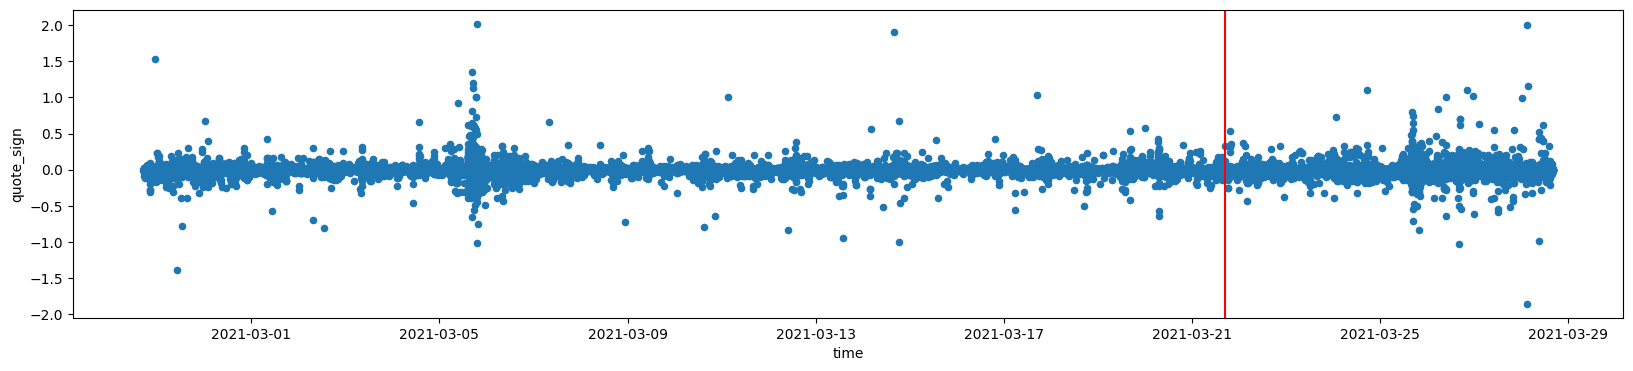

In [7]:
df_trades.plot.scatter(x="time", y="quote_sign", figsize=(20, 4))
plt.axvline(x=pump.time.floor("1h") - timedelta(days=7), color="red")
plt.show()

In [8]:
time_ub: pd.Timestamp = pump.time.floor("1h") - timedelta(hours=1)

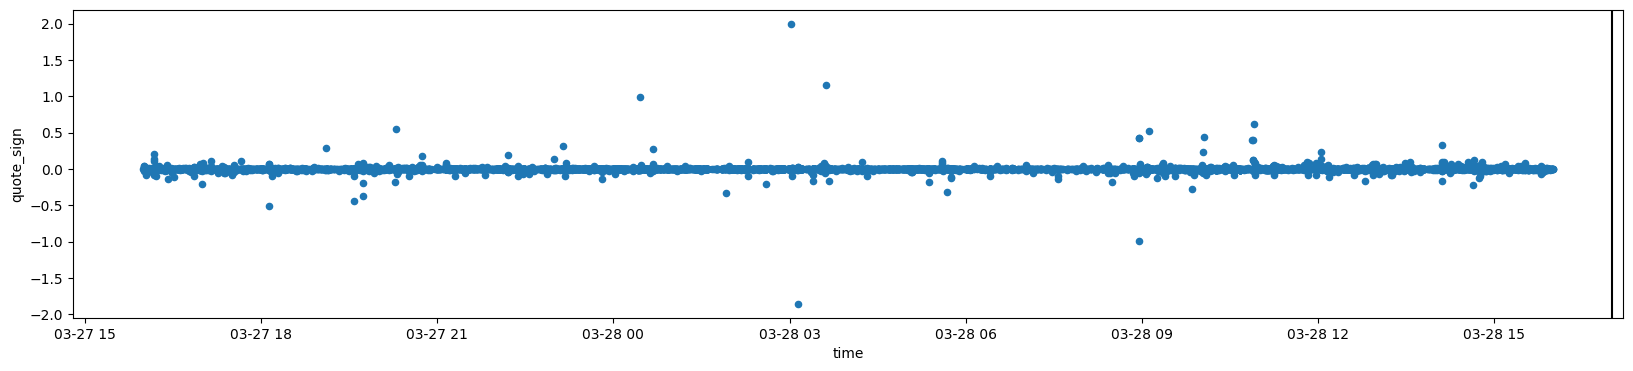

In [9]:
df_trades_1d: pd.DataFrame = df_trades[
    df_trades["time"] >= time_ub - timedelta(days=1)
].copy()

df_trades_1d.plot.scatter(x="time", y="quote_sign", figsize=(20, 4))
plt.axvline(x=pump.time.floor("1h"), color="black")

plt.show()

<h4>AUC Features</h4>

In [10]:
from sklearn.metrics import auc

In [11]:
df_candles_1h: pd.DataFrame = df_trades.resample(
    on="time", rule="1h", label="left", closed="left"
).agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    num_trades=("quote_abs", "count"),
    num_long_trades=("is_long", "sum"),
    quote_abs=("quote_abs", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_long=("quote_long", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_slippage_sign=("quote_slippage_sign", "sum")
).reset_index()

df_candles_1h.tail(10)

,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_long,quote_slippage_abs,quote_slippage_sign
709,2021-03-28 06:00:00,0.000031,0.000031,0.000031,0.000031,183,110,0.547697,-0.049741,0.248978,0.000573,-0.000396
710,2021-03-28 07:00:00,0.000031,0.000031,0.000031,0.000032,246,141,1.065904,-0.146227,0.457024,0.002065,-0.001929
711,2021-03-28 08:00:00,0.000031,0.000030,0.000030,0.000031,313,214,3.575629,-0.692615,1.441507,0.014517,-0.013979
712,2021-03-28 09:00:00,0.000030,0.000030,0.000029,0.000031,553,288,3.290201,-0.281640,1.504280,0.006435,0.003922
713,2021-03-28 10:00:00,0.000030,0.000031,0.000029,0.000031,424,129,4.679687,1.684070,3.181879,0.018157,0.014497
714,2021-03-28 11:00:00,0.000031,0.000032,0.000031,0.000033,447,182,2.281997,0.253853,1.267925,0.003085,-0.000558
715,2021-03-28 12:00:00,0.000032,0.000033,0.000032,0.000033,440,196,2.811298,0.217902,1.514600,0.002902,-0.001313
716,2021-03-28 13:00:00,0.000033,0.000033,0.000032,0.000033,222,94,1.459116,-0.175862,0.641627,0.000619,-0.000248
717,2021-03-28 14:00:00,0.000033,0.000034,0.000033,0.000034,609,274,4.277999,0.919342,2.598670,0.009730,0.000410
718,2021-03-28 15:00:00,0.000034,0.000034,0.000034,0.000035,496,177,1.965074,-0.319643,0.822201,0.001082,-0.000088


<h4>The hypothethis is that all volume related features will increase significantly in the run up to the pump</h4>

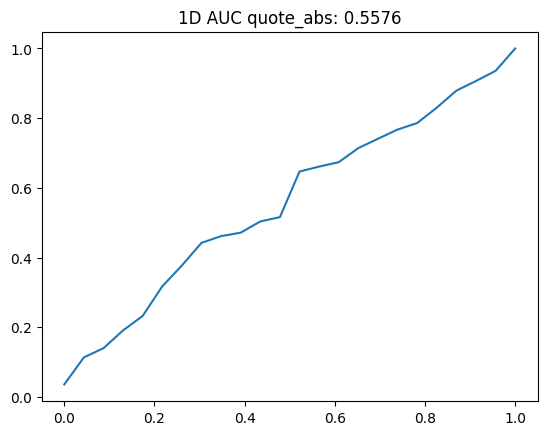

In [12]:
df_1d: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= time_ub - timedelta(days=1)
].copy()

df_1d_r = df_1d.iloc[::-1].copy()
df_1d_r["quote_abs_share"] = df_1d_r["quote_abs"].cumsum() / df_1d_r["quote_abs"].sum()

X = np.linspace(0, 1, 24)
auc_score: float = auc(x=X, y=df_1d_r["quote_abs_share"])

plt.plot(X, df_1d_r["quote_abs_share"])
plt.title(f"1D AUC quote_abs: {round(auc_score, 4)}")
plt.show()

<h4>12H AUC quote_abs</h4>

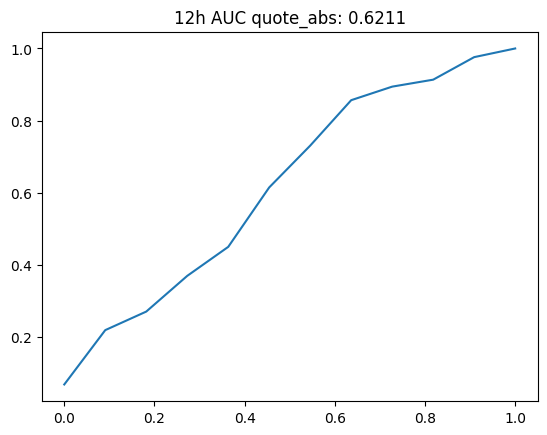

In [13]:
df_12h: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= time_ub - timedelta(hours=12)
].copy()

df_12h_r = df_12h.iloc[::-1].copy()
df_12h_r["quote_abs_share"] = df_12h_r["quote_abs"].cumsum() / df_12h_r["quote_abs"].sum()

X = np.linspace(0, 1, 12)
auc_score: float = auc(x=X, y=df_12h_r["quote_abs_share"])

plt.plot(X, df_12h_r["quote_abs_share"])
plt.title(f"12h AUC quote_abs: {round(auc_score, 4)}")
plt.show()

<h4>12h AUC long volume</h4>

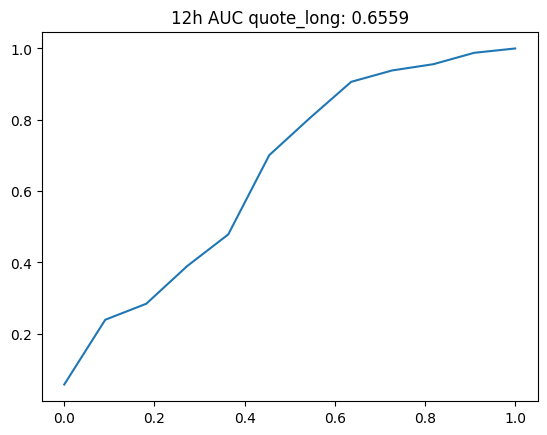

In [14]:
df_12h_r["quote_long_share"] = df_12h_r["quote_long"].cumsum() / df_12h_r["quote_long"].sum()

X = np.linspace(0, 1, 12)
auc_score: float = auc(x=X, y=df_12h_r["quote_long_share"])

plt.plot(X, df_12h_r["quote_long_share"])
plt.title(f"12h AUC quote_long: {round(auc_score, 4)}")
plt.show()

<h4>Share of long trades in the last 12h AUC</h4>

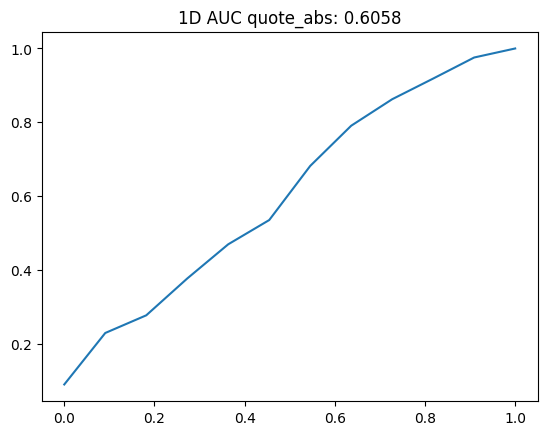

In [15]:
df_12h_r["num_long_trades_share"] = df_12h_r["num_long_trades"].cumsum() / df_12h_r["num_long_trades"].sum()

X = np.linspace(0, 1, 12)
auc_score: float = auc(x=X, y=df_12h_r["num_long_trades_share"])

plt.plot(X, df_12h_r["num_long_trades_share"])
plt.title(f"1D AUC quote_abs: {round(auc_score, 4)}")
plt.show()

<h4>Share of slippage in the last 12h AUC</h4>

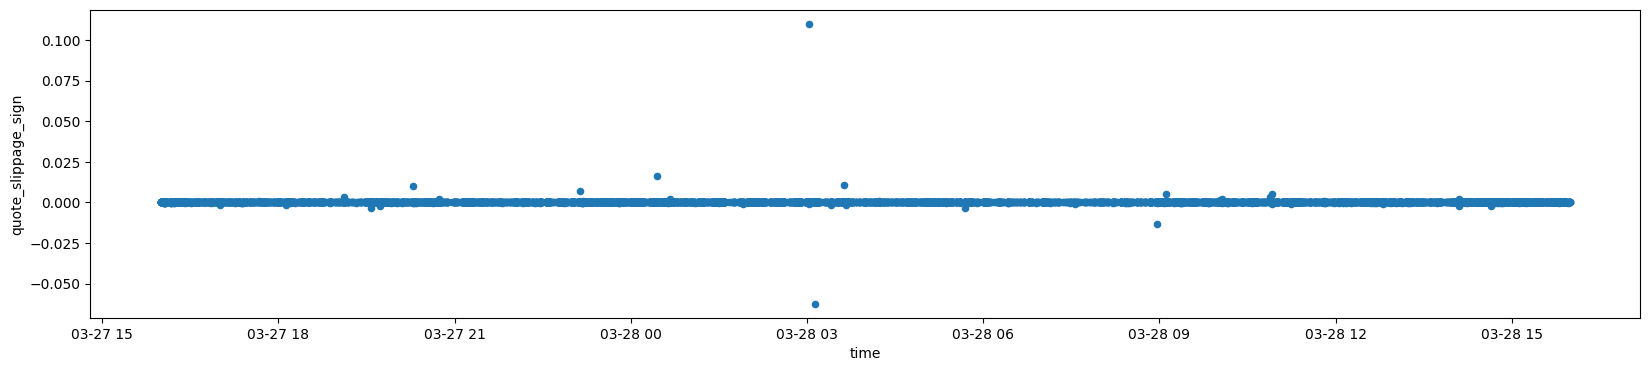

In [16]:
df_trades_1d.plot.scatter(
    x="time", y="quote_slippage_sign", figsize=(20, 4)
)
plt.show()

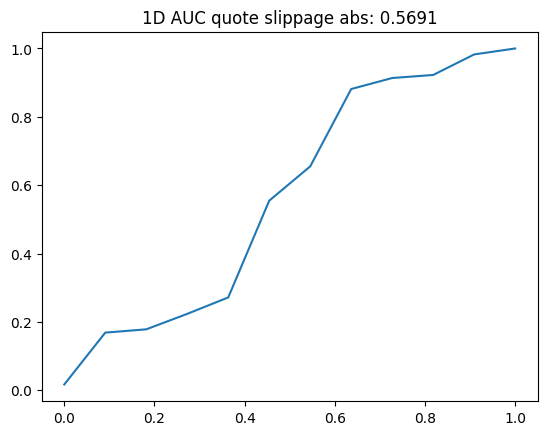

In [17]:
df_12h_r["quote_slippage_abs_share"] = df_12h_r["quote_slippage_abs"].cumsum() / df_12h_r["quote_slippage_abs"].sum()

X = np.linspace(0, 1, 12)
auc_score: float = auc(x=X, y=df_12h_r["quote_slippage_abs_share"])

plt.plot(X, df_12h_r["quote_slippage_abs_share"])
plt.title(f"1D AUC quote slippage abs: {round(auc_score, 4)}")
plt.show()

<h4>Sin, cos time features</h4>

In [18]:
total_day_seconds = 24*60*60

df_trades["day_seconds_elapsed"] = pd.to_timedelta(
    df_trades["time"].dt.time.astype(str)
).dt.total_seconds()

df_trades["sin_time"] = np.sin(2*np.pi*df_trades.day_seconds_elapsed / total_day_seconds)
df_trades["cos_time"] = np.cos(2*np.pi*df_trades.day_seconds_elapsed / total_day_seconds)
df_trades["time_diff"] = df_trades["time"].diff().dt.total_seconds()

df_trades = df_trades.dropna()

In [19]:
df_trades_7d: pd.DataFrame = df_trades[
    df_trades["time"] >= time_ub - timedelta(days=7)
].copy()

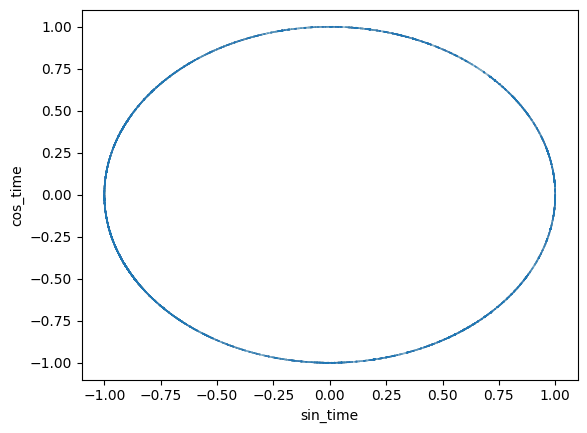

In [20]:
df_trades_7d.plot.scatter(
    x="sin_time", y="cos_time", 
    s=df_trades_7d["quote_abs"] / df_trades_7d["quote_abs"].max(), 
    alpha=.5
)
plt.show()

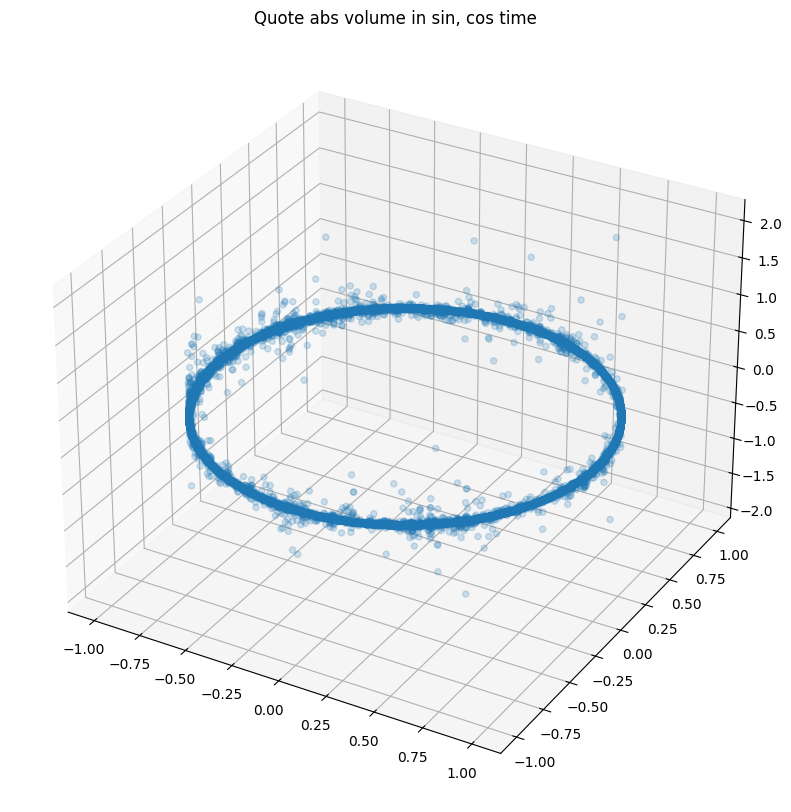

In [21]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")
ax.scatter(
    df_trades_7d["sin_time"], df_trades_7d["cos_time"], df_trades_7d["quote_sign"], alpha=.2
)

plt.title("Quote abs volume in sin, cos time")
plt.show()

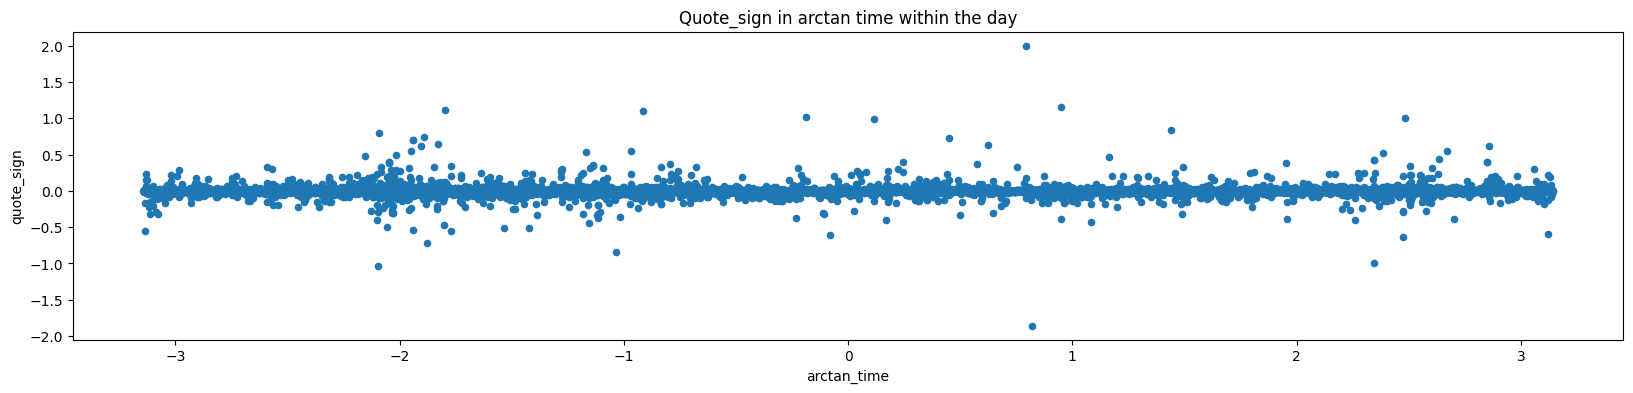

In [22]:
df_trades_7d["arctan_time"] = np.arctan2(df_trades_7d["sin_time"], df_trades_7d["cos_time"])

df_trades_7d.plot.scatter(x="arctan_time", y="quote_sign", figsize=(20, 4))
plt.title("Quote_sign in arctan time within the day")
plt.show()

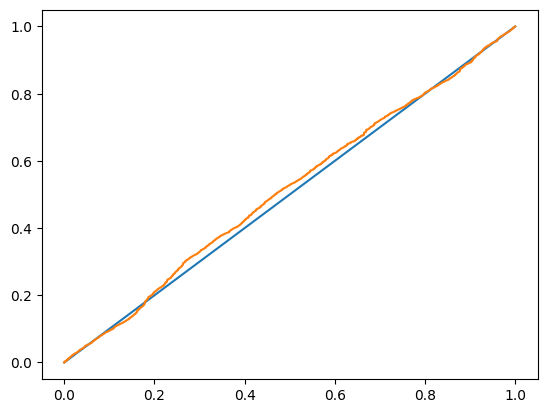

In [23]:
df_circle: pd.DataFrame = df_trades_7d.copy()
N = df_circle.shape[0]

df_circle = df_circle.sort_values(by="arctan_time", ascending=True).reset_index(drop=True)
df_circle["cumsum_ratio"] = df_circle["quote_abs"].cumsum() / df_circle["quote_abs"].sum()

X = np.linspace(0, 1, N)
Y = X

plt.plot(X, Y)
plt.plot(X, df_circle["cumsum_ratio"])

plt.show()

In [24]:
deviation_auc = auc(x=X, y=np.abs(df_circle["cumsum_ratio"] - Y))
deviation_auc

0.015010509514276626

<h4>Imbalance ratio AUC</h4>

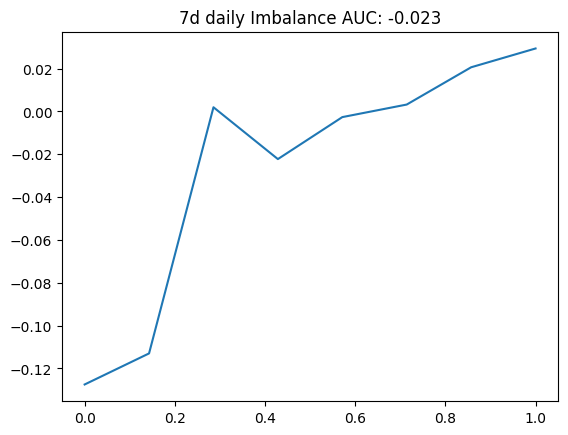

In [25]:
df_imbalance: pd.DataFrame = df_trades_7d.resample(on="time", rule="1d").agg(
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote_abs", "sum")
)

df_imbalance["imbalance_ratio"] = df_imbalance["quote_sign"] / df_imbalance["quote_abs"]
X = np.linspace(0, 1, df_imbalance.shape[0])
auc_score: float = auc(x=X, y=df_imbalance["imbalance_ratio"])

plt.plot(X, df_imbalance["imbalance_ratio"])
plt.title(f"7d daily Imbalance AUC: {round(auc_score, 4)}")
plt.show()

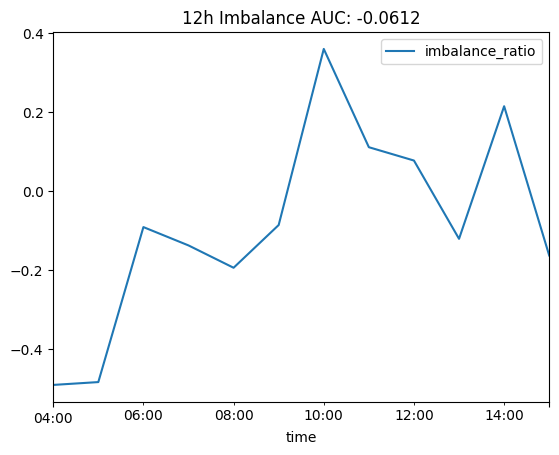

In [26]:
df_12h["imbalance_ratio"] = df_12h["quote_sign"] / df_12h["quote_abs"]
df_12h.plot(x="time", y="imbalance_ratio")

X = np.linspace(0, 1, 12)

auc_score: float = auc(x=X, y=df_12h["imbalance_ratio"])

plt.title(f"12h Imbalance AUC: {round(auc_score, 4)}")
plt.show()

<h4>Lorenz curve of quote volume</h4>

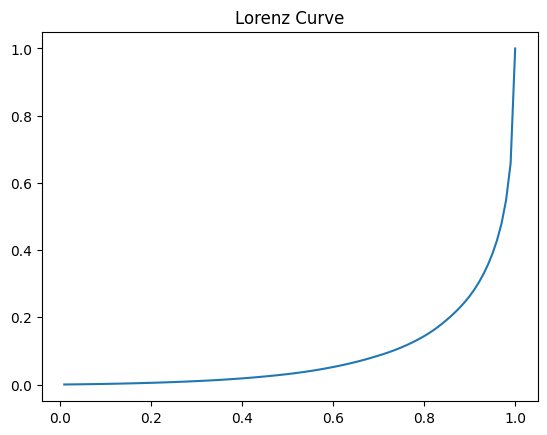

In [27]:
quantiles: np.array = np.linspace(0.01, 1, 100)
vol_shares: List[float] = []

overall_vol: float = df_trades_7d["quote_abs"].sum()

for quan in quantiles:
    vol_abs: float = df_trades_7d[
        df_trades_7d["quote_abs"] <= df_trades_7d["quote_abs"].quantile(quan)
    ]["quote_abs"].sum()
    vol_shares.append(
        vol_abs / overall_vol
    )

plt.title("Lorenz Curve")
plt.plot(quantiles, vol_shares)
plt.show()

In [28]:
lorenz_auc: float = auc(x=quantiles, y=vol_shares)
gini_index: float = (0.5 - lorenz_auc) / 0.5

gini_index

0.8187731558864911

<h4>Log returns</h4>

In [29]:
df_candles_1h["imbalance_ratio"] = df_candles_1h["quote_sign"] / df_candles_1h["quote_abs"]
df_candles_1h["long_trades_ratio"] = df_candles_1h["num_long_trades"] / df_candles_1h["num_trades"]
df_candles_1h["quote_slippage_imbalance_ratio"] = df_candles_1h["quote_slippage_sign"] / df_candles_1h["quote_slippage_abs"]

# calculate log returns
df_candles_1h["close"] = df_candles_1h["close"].ffill()
df_candles_1h["log_returns"] = np.log(df_candles_1h["close"] / df_candles_1h["close"].shift(1))
df_candles_1h = df_candles_1h.iloc[1:]
df_candles_1h = df_candles_1h.reset_index()

df_candles_1h.head(1)

,index,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_long,quote_slippage_abs,quote_slippage_sign,imbalance_ratio,long_trades_ratio,quote_slippage_imbalance_ratio,log_returns
0,1,2021-02-26 18:00:00,0.000029,0.000029,0.000029,0.000029,140,66,1.090184,-0.360542,0.364821,0.000924,0.000014,-0.330717,0.471429,0.015059,0.002434


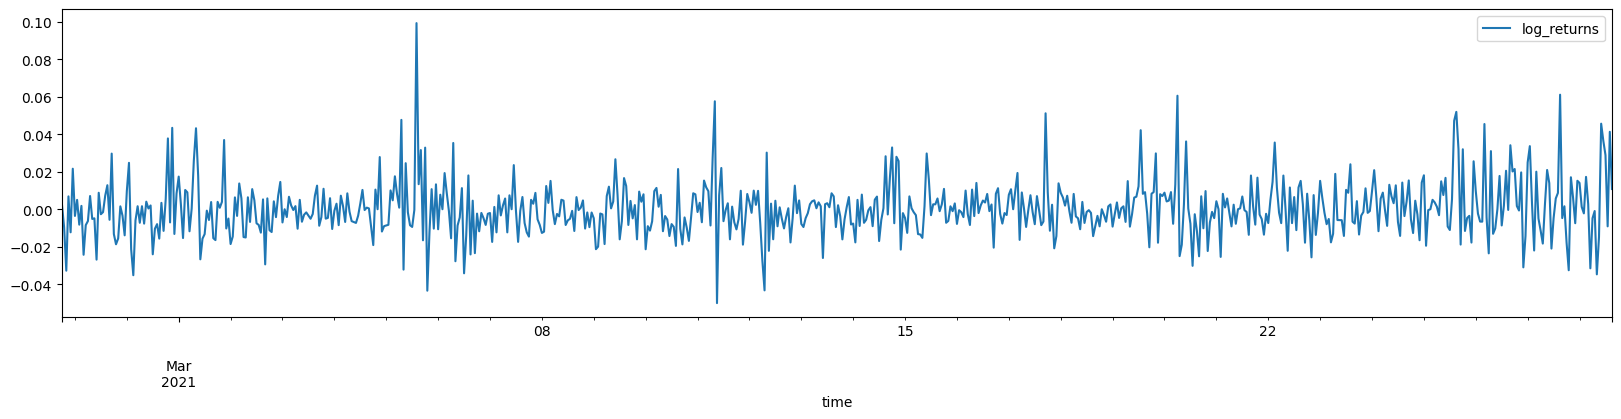

In [30]:
df_candles_1h.plot(x="time", y="log_returns", figsize=(20, 4))
plt.show()

In [31]:
df_30d: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= time_ub - timedelta(days=30)
].copy()

In [32]:
offsets: List[timedelta] = [
    timedelta(days=i) for i in [1, 3, 7, 14]
]

labels: List[str] = [
    f"{i}d" for i in [1, 3, 7, 14]
]

hourly_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval = df_candles_1h[
        df_candles_1h["time"] >= time_ub - offset
    ].copy()

    # Share of long trades scaled by long run moments 
    hourly_features[f"long_trades_1h_ratio_zscore_{label}"] = (
        df_interval["long_trades_ratio"].mean() - df_30d["long_trades_ratio"].mean()
    ) / df_30d["long_trades_ratio"].std()
    hourly_features[f"long_trades_1h_ratio_overall_{label}"] = df_interval["num_long_trades"].sum() / df_interval["num_trades"].sum()
    
    # Imbalance ratio features
    hourly_features[f"imbalance_ratio_1h_mean_{label}"] = df_interval["imbalance_ratio"].mean()
    hourly_features[f"imbalance_ratio_1h_std_{label}"] = df_interval["imbalance_ratio"].std()

    # Log returns features
    hourly_features[f"log_returns_1h_zscore_{label}"] = df_interval["log_returns"].mean() / df_30d["log_returns"].std()
    hourly_features[f"log_returns_1h_std_{label}"] = df_interval["log_returns"].std()

    hourly_features[f"quote_abs_1h_zscore_{label}"] = (
        df_interval["quote_abs"].mean() - df_30d["quote_abs"].mean()
    ) / df_30d["quote_abs"].std()

    # Quote slippage features
    hourly_features[f"quote_slippage_imbalance_ratio_1h_mean_{label}"] = df_interval["quote_slippage_imbalance_ratio"].mean()
    hourly_features[f"quote_slippage_imbalance_ratio_1h_std_{label}"] = df_interval["quote_slippage_imbalance_ratio"].std()
    # find slippage imbalance ratio over the whole interval
    hourly_features[f"quote_slippage_imbalance_ratio_1h_overall_{label}"] = (
        df_interval["quote_slippage_sign"].sum() / df_interval["quote_slippage_abs"].sum()
    )
    # Share of slippage in the whole volume
    hourly_features[f"quote_slippage_1h_quote_abs_ratio_{label}"] = df_interval["quote_slippage_abs"].sum() / df_interval["quote_abs"].sum()

In [33]:
len(hourly_features)

44

<h4>Powerlaw features</h4>

In [34]:
from scipy.stats import powerlaw


powerlaw_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= time_ub - offset)
    ].copy()

    # Compute alpha of powerlaw distribution for quote_abs, quote_long, quote_short
    powerlaw_features[f"quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(df_interval["quote_abs"])[0]
    # alpha for long trades
    powerlaw_features[f"long_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[df_interval["is_long"]]["quote_abs"]
    )[0]
    # alpha for short trades
    powerlaw_features[f"short_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[~df_interval["is_long"]]["quote_abs"]
    )[0]

len(powerlaw_features)

12

<h4>TSFresh features</h4>

In [35]:
from tsfresh.feature_extraction.feature_calculators import benford_correlation


benford_features: Dict[str, float] = {}


for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Benford correlation
    benford_features[f"benford_law_correlation_{label}"] = benford_correlation(df_interval["qty_abs"])


len(benford_features)

4

<h4>Quote interval features: Quantile ratios</h4>

In [36]:
quote_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= time_ub - offset)
    ].copy()

    df_long: pd.DataFrame = df_interval[df_interval["is_long"]].copy()
    df_short: pd.DataFrame = df_interval[~df_interval["is_long"]].copy()

    # 999 quantiles
    long_whale_quantile: float = df_long["quote_abs"].quantile(.999)
    short_whale_quantile: float = df_short["quote_abs"].quantile(.999)
    whale_quantile: float = df_interval["quote_sign"].quantile(.999)

    # 99 quantiles
    long_99_quantile: float = df_long["quote_abs"].quantile(.99)
    short_99_quantile: float = df_short["quote_abs"].quantile(.99)
    quantile_99: float = df_interval["quote_sign"].quantile(.99)

    # 95 quantiles
    long_95_quantile: float = df_long["quote_abs"].quantile(.95)
    short_95_quantile: float = df_short["quote_abs"].quantile(.95)
    quantile_95: float = df_interval["quote_sign"].quantile(.95)

    long_median_quote: float = df_long["quote_abs"].median()
    short_nedian_quote: float = df_short["quote_abs"].median()

    quote_features[f"long_whale_99_ratio_{label}"] = long_whale_quantile / long_99_quantile # how spread out long quantiles become
    quote_features[f"short_whale_99_ratio_{label}"] = short_whale_quantile / short_99_quantile
    quote_features[f"long_whale_short_whale_ratio_{label}"] = long_whale_quantile / short_whale_quantile # how extended is long quantile compared to short

    quote_features[f"long_99_long_95_ratio_{label}"] = long_99_quantile / long_95_quantile
    quote_features[f"short_99_95_ratio_{label}"] = short_99_quantile / short_95_quantile
    quote_features[f"long_99_short_99_ratio_{label}"] = long_99_quantile / short_99_quantile

    quote_features[f"long_whale_median_ratio_{label}"] = long_whale_quantile / long_median_quote
    quote_features[f"short_whale_median_ratio_{label}"] = short_whale_quantile / short_nedian_quote


len(quote_features)

32

<h4>Empty trades</h4>

In [37]:
# rebin data into 1min candles
df_candles_1min: pd.DataFrame = df_trades.resample(on="time", rule="1min", label="left", closed="left").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    num_trades=("quote_abs", "count"),
    num_long_trades=("is_long", "sum"),
    quote_abs=("quote_abs", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_slippage_sign=("quote_slippage_sign", "sum")
).reset_index()

df_candles_1min.head(2)

,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_slippage_abs,quote_slippage_sign
0,2021-02-26 17:00:00,0.000029,0.000029,0.000029,0.000029,2,1,0.001580,0.001230,0.0,0.0
1,2021-02-26 17:01:00,0.000029,0.000029,0.000029,0.000029,2,2,0.001025,0.001025,0.0,0.0


In [38]:
empty_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_candles_1min[
        (df_candles_1min["time"] >= time_ub - offset)
    ].copy()

    empty_features[f"empty_trading_minutes_ratio_{label}"] = df_interval[df_interval["num_trades"] == 0].shape[0] / df_interval.shape[0]

empty_features

{'empty_trading_minutes_ratio_1d': 0.09930555555555555,
 'empty_trading_minutes_ratio_3d': 0.0798611111111111,
 'empty_trading_minutes_ratio_7d': 0.17371031746031745,
 'empty_trading_minutes_ratio_14d': 0.24503968253968253}

<h4>Short run features</h4>

In [39]:
offsets: List[timedelta] = [
    timedelta(hours=i) for i in [1, 2, 5, 7, 12]
]

labels: List[str] = [
    f"{i}h" for i in [1, 2, 5, 7, 12]
]

short_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades_1d[
        df_trades_1d["time"] >= time_ub - offset
    ].copy()

    df_long: pd.DataFrame = df_interval[df_interval["is_long"]].copy()
    df_short: pd.DataFrame = df_interval[~df_interval["is_long"]].copy()

    # Share of long trades within the time interval and the whole day 
    short_features[f"long_trades_ratio_{label}"] = df_interval["is_long"].sum() / df_interval.shape[0]
    short_features[f"long_trades_ratio_{label}_1d"] = df_interval["is_long"].sum() / df_trades_1d.shape[0]
    # Share of volume within the time interval and the whole day
    short_features[f"quote_abs_ratio_{label}_1d"] = df_interval["quote_abs"].sum() / df_trades_1d["quote_abs"].sum()
    short_features[f"quote_abs_long_ratio_{label}_1d"] = df_long["quote_abs"].sum() / df_interval["quote_abs"].sum()
    # Imbalance ratio
    short_features[f"imbalance_ratio_{label}"] = df_interval["quote_sign"].sum() / df_interval["quote_abs"].sum()
    # Quote slippage features
    short_features[f"quote_slippage_ratio_{label}_1d"] = df_interval["quote_slippage_abs"].sum() / df_trades_1d["quote_slippage_abs"].sum() # share of overall slippage
    short_features[f"quote_slippage_imbalance_ratio_{label}"] = df_interval["quote_slippage_sign"].sum() / df_interval["quote_slippage_abs"].sum()
    # Share of slippage quote compared to volume
    short_features[f"quote_slippage_quote_abs_ratio_{label}"] = df_interval["quote_slippage_abs"].sum() / df_interval["quote_abs"].sum()


len(short_features)

40

<h4>Quote USDT features</h4>

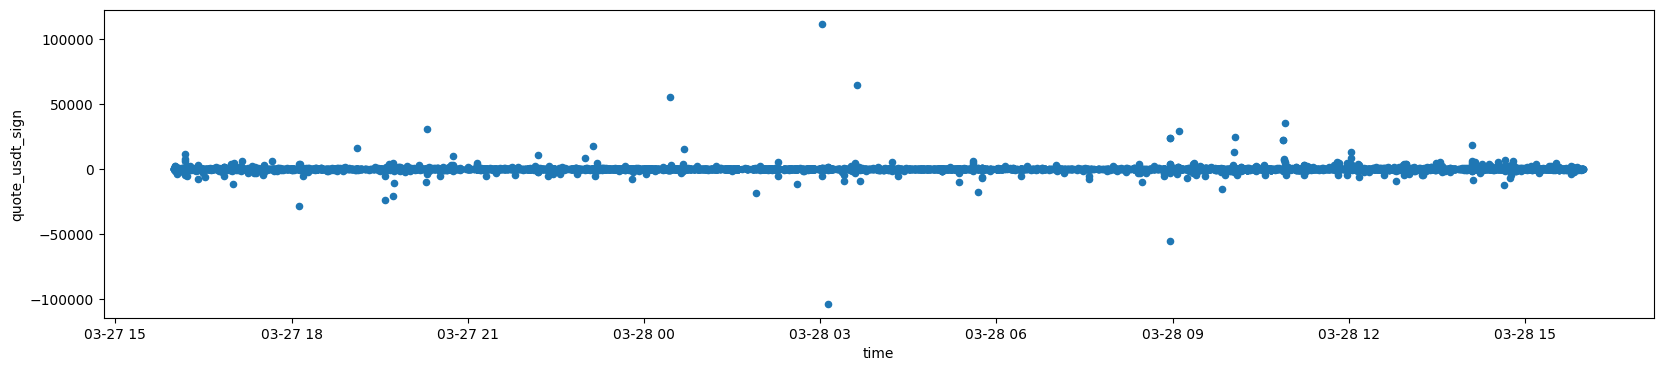

In [40]:
df_trades_1d.plot.scatter(x="time", y="quote_usdt_sign", figsize=(20, 4))
plt.show()

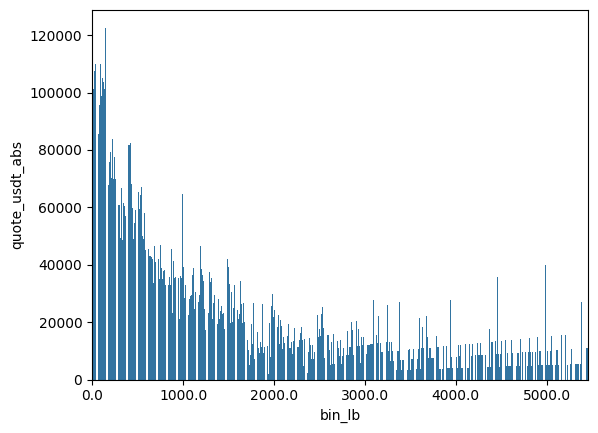

In [41]:
import matplotlib.ticker as ticker

bins = np.arange(0, df_trades_7d["quote_usdt_abs"].quantile(.99), 10)

df_trades_7d["quote_usdt_bin"] = pd.cut(df_trades_7d["quote_usdt_abs"], bins=bins, right=False)
df_binned_vol: pd.DataFrame = df_trades_7d.groupby("quote_usdt_bin", observed=False)["quote_usdt_abs"].sum().to_frame()

df_binned_vol["bin_lb"] = bins[:-1]

ax = sns.barplot(data=df_binned_vol, x="bin_lb", y="quote_usdt_abs")
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

plt.show()